# Setup
Let's begin by importing all the necessary libraries for our analysis. Please note that this process might take some time.

In [1]:
%load_ext autoreload
%autoreload 2

import re

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from pywaffle import Waffle
from scipy.stats import pearsonr, ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import statsmodels.formula.api as smf

from utils import *

We utilize two primary datasets in our work:

1. **`book_adaptation` Dataset:** This dataset contains information about movies and, when applicable, the books from which they were adapted.

2. **`book` Dataset:** This dataset includes details about books that may not necessarily have movie adaptations.

For an in-depth understanding of how these datasets were created, refer to the Jupyter Notebook `create_dataset.ipynb`.

In [2]:
adaptation_df = pd.read_csv('book_adaptation.csv')
book_df = pd.read_csv('book.csv')

The primary success criterion for our analysis is the revenue generated by each movie. However, we face a challenge since this information is not available for all movies in the dataset. 

To address this, our first step will be to plot the missing revenue entries by year. This will enable us to assess if the availability of revenue data has varied over time, thereby influencing our analysis and interpretations.

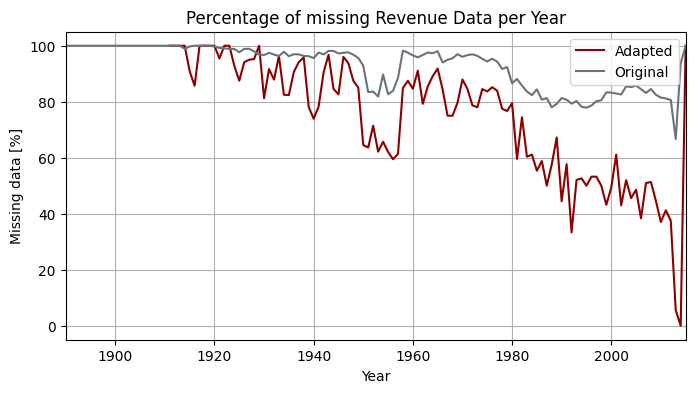

In [3]:
missing_revenue_adaptation_df = (adaptation_df
                                 .query('movie_is_adaptation')
                                 .groupby('movie_release')
                                 ['movie_revenue']
                                 .apply(lambda x: (x.isna().sum()/len(x) * 100))
                                )
missing_revenue_original_df = (adaptation_df
                              .query('~movie_is_adaptation')
                              .groupby('movie_release')
                              ['movie_revenue']
                              .apply(lambda x: (x.isna().sum()/len(x) * 100))
                              )      
plt.figure(figsize=(8, 4))
plt.plot(missing_revenue_adaptation_df.index, missing_revenue_adaptation_df.values, label='Adapted', color='#8B0000')
plt.plot(missing_revenue_original_df.index, missing_revenue_original_df.values, label='Original', color='#6a737b')
plt.xlabel('Year')
plt.ylabel('Missing data [%]')
plt.title('Percentage of missing Revenue Data per Year')
plt.xlim([1890, 2015])
plt.legend()
plt.grid()


**Pre-1920 Data Gap.**
There is a significant lack of revenue data for movies released before 1920.

**Analysis Timeframe.** 
The period from 1950 until 2010 shows the lowest proportion of missing revenue data, making it ideal for analysis. Specifically, the missing data is around 50% for movies based on books and approximately 80% for other movies.

**Less missing Data for Adaptations.** 
Movies adapted from books exhibit a lower proportion of missing revenue data.

**Bias towards popular Movies.** 
On Wikidata, entries for larger, more popular movies are often more comprehensive. The presence of the `based on` field, which we use to identify adaptations, suggests a movie has a detailed Wikidata page. Consequently, our adaptation dataset may exhibit a bias toward these larger, more popular movies. It's also reasonable to assume that revenue data for such movies is more complete, with fewer missing values. This factor could account for the differences observed in our plot.

For our analysis, we will concentrate on the timeframe from 1950 to 2010. Prior to 1950, the data has an excessive number of missing values. Additionally, we believe that movies from the early 20th century were significantly different from today's films, which could complicate a uniform analysis across both eras.

In [4]:
adaptation_df = adaptation_df.query('movie_release >= 1950 and movie_release <= 2010')

At first, determine the proportion of movies in the CMU dataset that are based on books, as identified through Wikidata. The analysis will be visually represented using a waffle plot. 

The percentage of adaptation in our dataset is 6.174%


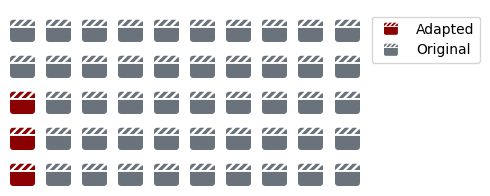

In [5]:
fraction_adapted = round(adaptation_df.movie_is_adaptation.mean() * 100) / 2
fraction_original = (50 - fraction_adapted)
data = {'Adapted': fraction_adapted, 'Original': fraction_original}
print("The percentage of adaptation in our dataset is %.3f%%" %(adaptation_df.movie_is_adaptation.mean() * 100))
fig = plt.figure(
    figsize=(5, 5),
    FigureClass=Waffle,
    rows=5,
    values=data,
    colors=['#8B0000', '#6a737b'],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons=['clapperboard', 'clapperboard'],
    font_size=18,
    icon_legend=True
)
fig.savefig('assets/adaptation_fraction.png', dpi=600, bbox_inches='tight')

The percentage of adaptations in our dataset is unexpectedly low. According to Frontier Economics, [35% of all English-language films are derived from books](https://www.frontier-economics.com/media/vyfd1iz3/publishings-contribution-to-the-wider-creative-industries.pdf). However, it's important to remember that the data from Wikidata might be incomplete, potentially impacting our analysis. This is a crucial consideration as we proceed with our evaluation.

Since movie revenue is a key variable in our analysis, let's examine its distribution more closely by plotting a CCDF plot. 

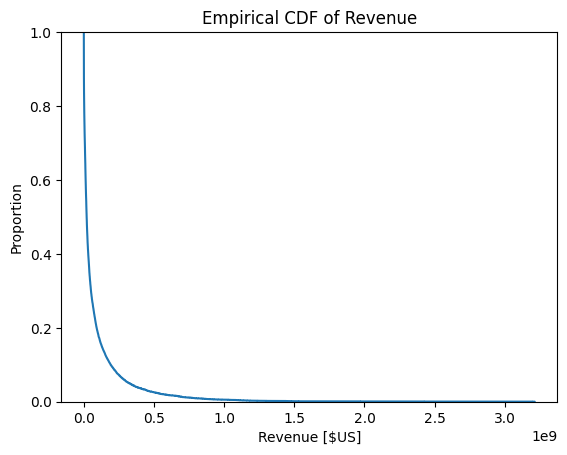

In [6]:
revenue = adaptation_df['movie_revenue'].dropna()
sns.ecdfplot(revenue, complementary=True)
plt.xlabel('Revenue [$US]')
plt.title('Empirical CDF of Revenue')
plt.show()

The distribution is heavy tailed, and thus most of the revenues are shown in a very small part of the plot; in the far left of the plot. One solution to this is to log the x-axis.

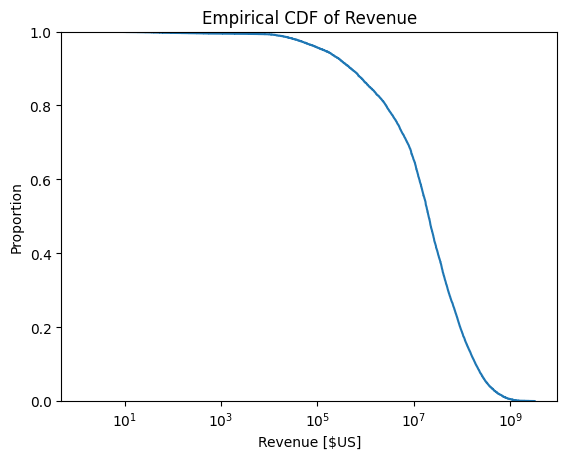

In [7]:
sns.ecdfplot(revenue, complementary=True)
plt.xscale('log')
plt.xlabel('Revenue [$US]')
plt.title('Empirical CDF of Revenue')
plt.show()

The log transformation appears to be a better fit for our data. Therefore, let's proceed by transforming the dataset accordingly.

In [8]:
# additionally we will work with log of revenue
adaptation_df['movie_revenue_log'] = np.log10(adaptation_df.movie_revenue)

# 1. How do book adaptations compare to original movies?
The adaptation_df dataset offers insights into both original and adapted movies. Let's begin by comparing these two categories in terms of their key aspects: revenue and rating.

### 1.1 Do movies based on books perform better at the box office?
We aim to determine whether movie adaptations are more successful at the box office in terms of revenue compared to non-adapted movies.

**Possible Confounding Variables**
- `Genre`: Certain genres, like fantasy, might be more prevalent in book adaptations. If these genres inherently perform better at the box office, the success cannot be solely attributed to the movie being an adaptation.
- `Temporal Trends`: The frequency of book adaptations and the general success of cinema have evolved over time. This temporal variation could impact our analysis.
- `Budget`: Adaptations might tend to have larger budgets, which could inherently lead to a higher box office revenue.
- `Country`: It could be that in certain countries (think of India with Bollywood) book adaptations are less frequent while movies in these countries have a differnt performance at the box office. 
- `Movie runtime`: The movie runtime might influence the tickets price, thus the box office.

To mitigate the influence of these confounding variables, we will employ a combination of `Exact Matching` and `Matching with Propensity Scores` as outlined in the lecture. This approach will allow us to more accurately isolate the effect of being a book adaptation on a movie's box office success, controlling for other influencing factors.

We begin by parsing the provided dictionary data to extract information about movie genres and countries of production.

1. Parsing Dictionary Data: Extract genre and country details from the dictionary format.
   
2. Selecting Frequent Values: Focus on the top 50 genres and the top 15 countries. These selections cover 85% of all values in the dataset, ensuring a comprehensive yet focused analysis.

3. Creating One-Hot Variables: For each movie, we will create one-hot encoded variables for these genres and countries.

In [9]:
%%capture
adaptation_df = (adaptation_df
                 .assign(
                     movie_countries = lambda x: x.movie_countries.apply(parse_string_to_dict),
                     movie_genres = lambda x: x.movie_genres.apply(parse_string_to_dict),
                 )
                 .assign(
                        movie_countries = lambda x: x.movie_countries.apply(lambda y: list(y.values())), 
                        movie_genres = lambda x: x.movie_genres.apply(lambda y: list(y.values())),
                  )
                )

top_genres = adaptation_df.movie_genres.explode().value_counts()[:50].index.tolist()
top_countries = adaptation_df.movie_countries.explode().value_counts()[:15].index.tolist()

for genre in top_genres:
    adaptation_df[f'movie_genre_{genre.lower().replace(" ", "_")}'] = adaptation_df.movie_genres.apply(lambda x: genre in x).astype(int)
for country in top_countries:
    adaptation_df[f'movie_country_{country.lower().replace(" ", "_")}'] = adaptation_df.movie_countries.apply(lambda x: country in x).astype(int)
adaptation_df = adaptation_df.copy(deep=True)


In [10]:
# Print the genres and countries kept
print(f"The top genres are: {', '.join(top_genres)}\n")
print(f"The top countries are: {', '.join(top_countries)}")

The top genres are: Drama, Comedy, Romance Film, Thriller, World cinema, Action, Crime Fiction, Horror, Indie, Documentary, Action/Adventure, Adventure, Short Film, Family Film, Romantic drama, Musical, Science Fiction, Fantasy, Animation, Mystery, Romantic comedy, Comedy film, Black-and-white, Japanese Movies, War film, Crime Thriller, Period piece, Comedy-drama, Film adaptation, Chinese Movies, Biography, Bollywood, Psychological thriller, Western, LGBT, Sports, Black comedy, Television movie, Family Drama, Parody, Music, Teen, Biographical film, Martial Arts Film, Coming of age, Children's/Family, Cult, History, Slasher, Political drama

The top countries are: United States of America, India, United Kingdom, France, Italy, Japan, Canada, Germany, Argentina, Hong Kong, Spain, Australia, South Korea, Netherlands, West Germany


In [11]:
# select only entries with budget and revenue data available
trial_1_df = (adaptation_df
                .query('movie_budget.notnull() & movie_revenue.notnull()')
                .reset_index(drop=True)
             )


# select relevant columns for trial
genre_cols = [col for col in trial_1_df.columns if col.startswith('movie_genre_')]
country_cols = [col for col in trial_1_df.columns if col.startswith('movie_country_')]
other_cols = ['movie_release', 'movie_runtime', 'movie_budget']
relevant_cols = genre_cols + country_cols + other_cols

X_df = trial_1_df[relevant_cols]
y_df = trial_1_df['movie_is_adaptation']


# logisitic regression to compute propensity scores
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])
pipe.fit(X_df, y_df)
trial_1_df['propensity_score'] = pipe.predict_proba(X_df)[:,1]


# match treatment and control groups
treatment_df = trial_1_df.query('movie_is_adaptation')
control_df = trial_1_df.query('~movie_is_adaptation')

G = nx.Graph()
for control_id, control_row in tqdm(control_df.iterrows(), total=len(control_df), desc='Building Graph'):
    for treatment_id, treatment_row in treatment_df.iterrows():
        # only match movies with same release year to make optimization faster
        if control_row['movie_release'] != treatment_row['movie_release']:
            continue
        similarity = get_similarity(control_row['propensity_score'],
                                    treatment_row['propensity_score'])
        if similarity < 0.975:
            continue
        G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

print("Computing Max Weight Matching...")
matching = nx.max_weight_matching(G)
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
trial_1_balanced_df = trial_1_df.iloc[matched]

Building Graph: 100%|██████████| 3721/3721 [03:49<00:00, 16.21it/s]


Computing Max Weight Matching...


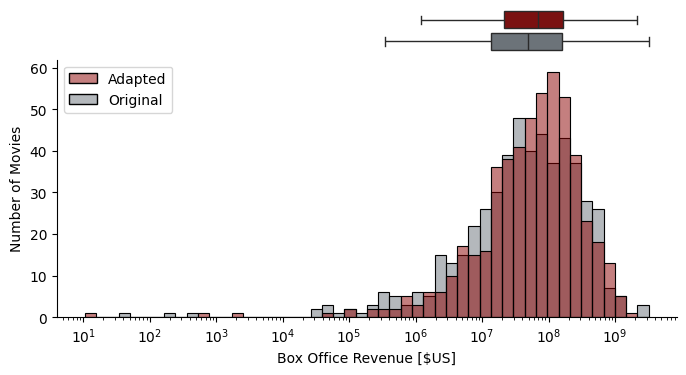

In [12]:
plot_revenue_histogram(df=trial_1_balanced_df)

From the histogram we can see a observe that adapted movies tend to have a slightly higer revenue than original movies. To quantify this difference: 
1. Check if this is a significant difference at the 5% significance level
2. Fit linear model to determine the average influence to the movie revenue

In [13]:
# compute t-test
test_result = ttest_ind(trial_1_balanced_df.query('movie_is_adaptation').movie_revenue_log,
          trial_1_balanced_df.query('~movie_is_adaptation').movie_revenue_log)
print(f'The p-value of the t-test is {test_result.pvalue:.4f}')

# fit linear model to compute impact
model = smf.ols('movie_revenue_log ~ movie_is_adaptation', data=trial_1_balanced_df)
results = model.fit()
intercept = results.params[0]
slope = results.params[1]
book_adaptation_impact_million = (10**(intercept + slope) - 10**intercept)/1e6
print(f'Impact of Adaptation [in million $US]: {book_adaptation_impact_million:.2f}')

The p-value of the t-test is 0.0192
Impact of Adaptation [in million $US]: 12.93


We have obtained a significant result (at the 5% level) with a p-value of approximately 2%. So there seems to be a difference between original and adapted movies when it comes to the box office. Now consider the fitted linear regression model we can see that on average, movies based on books generate about 13 million dollars more in revenue than those which are not book adaptations. 

### 1.2 Are movies based on books better, according to IMDB ratings?
While this might be of great interest to Hollywood executives (albeit very few might be reading this), as movie enthusiasts, our main concern often lies with the quality of these films. It's a common perception that movie adaptations disappoint fans of the original books. But is this really true? Do book adaptations generally result in lower-quality movies? To explore this, we'll analyze ratings from IMDb.

**Possible Confounding Variables**
- `Genre`: Some genres, such as fantasy, may be more common in book adaptations. If these genres generally receive higher ratings, then the observed differences in ratings cannot be attributed solely to a movie being an adaptation.
- `Temporal Trends`: The proportion of book adaptations and the average movie ratings have changed over time. Such variations could influence our analysis.
- `Country`: In certain countries, like India with Bollywood, book adaptations might be rarer, while movies from these regions could have notably different average ratings.
- `Movie runtime`: The duration of a movie might also affect its rating.

To minimize the impact of these confounding variables, we plan to use a combination of `Exact Matching` and Matching with `Propensity Scores`, as discussed in the lecture. This method will enable us to more effectively isolate the effect of being a book adaptation on a movie's rating, while controlling for other influencing factors.

In [14]:
# select only entries with imdb rating not null 
trial_2_df = (adaptation_df
                .query('imdb_rating.notnull()')
                .reset_index(drop=True)
             )

X_df = trial_2_df[relevant_cols]
y_df = trial_2_df['movie_is_adaptation']


# logisitic regression to compute propensity scores
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])
pipe.fit(X_df, y_df)
trial_2_df['propensity_score'] = pipe.predict_proba(X_df)[:,1]


# match treatment and control groups
treatment_df = trial_2_df.query('movie_is_adaptation').reset_index(drop=False)
control_df = trial_2_df.query('~movie_is_adaptation').reset_index(drop=False)

matching_df = (treatment_df
               .merge(
                   control_df, 
                   on=['movie_release'] + genre_cols[:15] + country_cols[:5], 
                   suffixes=['_treatment', '_control']
                   )
               .assign(
                     similarity = lambda x: x.apply(lambda y: get_similarity(y.propensity_score_treatment, y.propensity_score_control), axis=1)
               )
               .query('similarity > 0.975')
            )

G = nx.Graph()
for _, row in tqdm(matching_df.iterrows(), total=len(matching_df), desc='Building Graph'):
    similarity = row.similarity
    index_control = row['index_control']
    index_treatment = row['index_treatment']
    G.add_weighted_edges_from([(index_control, index_treatment, similarity)])

print('Computing Maximum Weight Matching...')
matching = nx.max_weight_matching(G)
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
trial_2_balanced_df = trial_2_df.iloc[matched]

Building Graph: 100%|██████████| 14258/14258 [00:01<00:00, 10678.46it/s]


Computing Maximum Weight Matching...


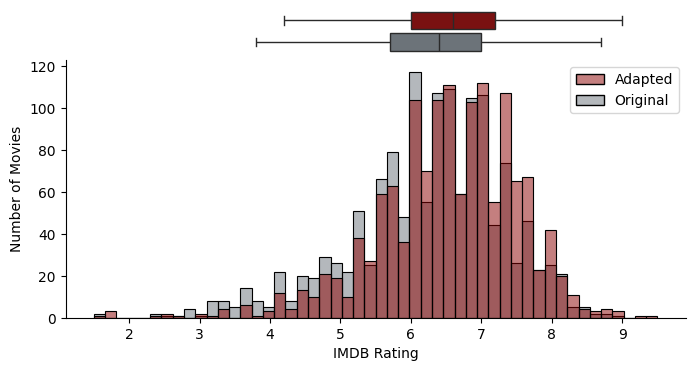

In [15]:
plot_imdb_histogram(df=trial_2_balanced_df)

In [16]:
test_result = ttest_ind(trial_2_balanced_df.query('movie_is_adaptation').imdb_rating,
                        trial_2_balanced_df.query('~movie_is_adaptation').imdb_rating)
print(f'The p-value of the t-test is {test_result.pvalue:.3e}')

model = smf.ols('imdb_rating ~ movie_is_adaptation', data=trial_2_balanced_df)
results = model.fit()
slope = results.params[1]
print(f'Book Adaptation Impact on Rating: {slope:.2f}')

The p-value of the t-test is 1.321e-12
Book Adaptation Impact on Rating: 0.28


Again, the p-value is significant at the 5% level, indicating a clear difference in IMDB ratings between adapted and original movies. According to our fitted linear regression model, adapted movies have, on average, a rating that is 0.3 points higher. This suggests that adaptations tend to be slightly better movies. A possible explanation is that if a book is adapted into a film, the story has already proven its appeal to readers.

# 2. What kind of books are turned into movies?
In the first section of our analysis, we observed that adaptations generally perform better at the box office and also tend to receive higher ratings compared to original movies. As a Hollywood executive considering adapting a book for our next production, an important question arises: Which book should we adapt? To address this, we will analyze books that have been adapted in the past, aiming to predict which non-adapted ones might be suitable for future adaptations.

To proceed, we will merge the books from the adaptation_df (those that have already been adapted) with those from the book_df (those not yet adapted). For our analyses, we will focus solely on books for which we have data from Wikimedia as well as Goodreads ratings.

In [17]:
# Select book-related columns from the adaptation dataset and filter out entries wiith missing book-data.
book_cols = [col for col in adaptation_df.columns if col.startswith('book_')]

adapted_book_df = (adaptation_df
                   .query('movie_is_adaptation == 1 & book_rating.notna()')
                   .assign(book_adapted = 1)
                   .loc[:, book_cols + ['book_adapted']]
                   .reset_index(drop=True)
                )

# Make sure that we do not consider books that have an adaptation in the book_df
adapted_wikidata_ids = adapted_book_df['book_wikidata_id'].unique()

book_df = (book_df
           .query('book_wikidata_id not in @adapted_wikidata_ids')
           .assign(book_adapted = 0)
           .loc[:, book_cols + ['book_adapted']]
           .reset_index(drop=True)
          )

# As we only consider movies between 1950 and 2010, we will only consider books that were published until 2010
adapted_book_df = (
                   pd.concat([book_df, adapted_book_df], axis=0)
                   .reset_index(drop=True)
                   .assign(
                        label=lambda x: x.book_adapted.map({1: "Adapted", 0: "Not-Adapted"}).astype("category").cat.reorder_categories(["Not-Adapted", "Adapted"], ordered=True)
                   )
                   .query('book_release <= 2010')
                  )

fiction_cols = adapted_book_df.columns[7:9].tolist()
genre_cols = adapted_book_df.columns[9:20].tolist()

### 2.1 When where the adapted books published?
At first, let us compare the year of publication between adapted and non-adapted book. Can we observe some clear differences? 

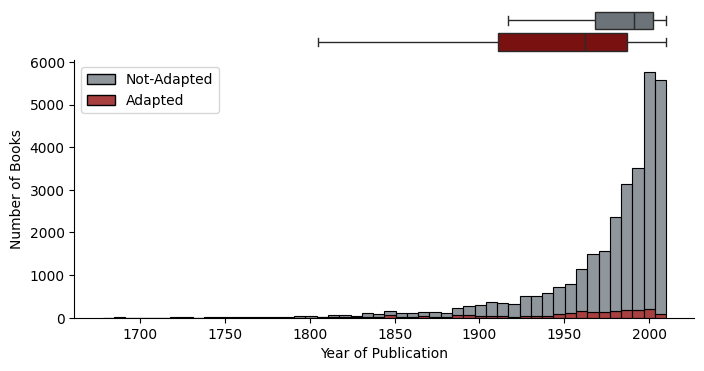

The p-value of the t-test is 1.091e-255.
The average adapted books is 31.34 years older than the average non-adapted book.


In [18]:
make_book_histplot(df=adapted_book_df, col='book_release', x_label='Year of Publication')

# Compute the t-test
test_result = ttest_ind(adapted_book_df.query('book_adapted == 1 & book_release.notna()').book_release,
                        adapted_book_df.query('book_adapted == 0 & book_release.notna()').book_release)
print(f'The p-value of the t-test is {test_result.pvalue:.3e}.')

# Compute the difference in means
diff_means = adapted_book_df.query('book_adapted == 1').book_release.mean() - adapted_book_df.query('book_adapted == 0').book_release.mean()
print(f'The average adapted books is {-diff_means:.2f} years older than the average non-adapted book.')

From the plot, it's evident that the books which are adapted are generally older. One possible explanation could be that Hollywood executives prefer to adapt classics that have already stood the test of time.

The difference between the distributions of adapted and non-adapted books might stem from variations in production rates. While movie production rates are limited by the resources of their time, book publication rates have increased due to the democratization and popularization of writing. This trend is particularly noticeable for books published after 1990.

Another factor is the time it takes for a book to be adapted into a film. Even if a producer were to start working on an adaptation the day a book is published, which is highly unlikely, it would still take several years to complete the adaptation. Therefore, many books published between 2000 and 2010 are likely still awaiting adaptation, explaining the slight decrease in adaptations after 2000.

Given these observations, let's refine our analysis by only considering books published before 1990, as these have had sufficient time to potentially be adapted.

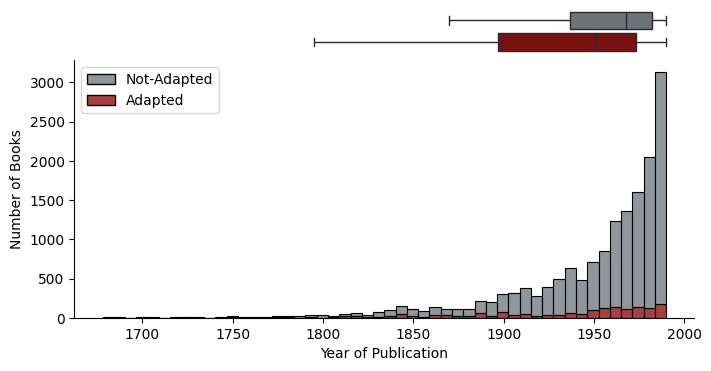

The p-value of the t-test is 1.077e-75.
The average adapted books is 21.16 years older than the average non-adapted book.


In [19]:
adapted_book_before_1990_df = adapted_book_df.query('book_release <= 1990')

make_book_histplot(df=adapted_book_before_1990_df, col='book_release', x_label='Year of Publication')

# Compute the t-test
test_result = ttest_ind(adapted_book_before_1990_df.query('book_adapted == 1 & book_release.notna()').book_release,
                        adapted_book_before_1990_df.query('book_adapted == 0 & book_release.notna()').book_release)
print(f'The p-value of the t-test is {test_result.pvalue:.3e}.')

# Compute the difference in means
diff_means = adapted_book_before_1990_df.query('book_adapted == 1').book_release.mean() - adapted_book_before_1990_df.query('book_adapted == 0').book_release.mean()
print(f'The average adapted books is {-diff_means:.2f} years older than the average non-adapted book.')

While less drastic there still seems to be a significant difference between adapted and non-adapted books in terms of publication year. 

### 2.2 Do books that are adapted into movies typically have higher ratings on Goodreads?
Another question we need to consider is whether filmmakers tend to adapt higher-quality books. For this, we'll look at the Goodreads ratings of the books. However, we must be mindful of some confounding variables that could bias our analysis:
- `publication year`: As observed in section 2.1, adapted books are often older. There's a possibility that older books might have higher ratings in our dataset, as lesser-quality books from those times might not be listed on Goodreads. This aspect requires careful consideration.
- `genre`: Certain genres might be more conducive to adaptations. If there are rating disparities within book genres, this could influence our analysis.
To account for these potential confounders, we will use exact matching. For publication year, we will group years into 5-year buckets.

Also, we only consider books that have at least 10 ratings to make sure that the average rating is somewhat reliable. 

In [20]:
# match treatment and control groups
trial_3_df = (adapted_book_df
              .assign(
                  book_release_bin = adapted_book_df.book_release // 5 * 5
                  )
              .query('book_rating.notna() & book_ratings_count > 10')
            )

treatment_df = trial_3_df.query('book_adapted == 1').reset_index(drop=False)
control_df = trial_3_df.query('book_adapted == 0').reset_index(drop=False)

# exact matching on book release year, fiction and genre
matching_df = (treatment_df
               .merge(
                   control_df, 
                   on=['book_release_bin'] + fiction_cols + genre_cols, 
                   suffixes=['_treatment', '_control'],
                   how='inner'
                   )
            )

# build graph for matching
G = nx.Graph()
for _, row in tqdm(matching_df.iterrows(), total=len(matching_df), desc='Building Graph'):
    index_control = row['index_control']
    index_treatment = row['index_treatment']
    G.add_edges_from([(index_control, index_treatment)])

print('Computing Maximum Matching...')
matching = nx.maximal_matching(G)
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
trial_3_balanced_df = trial_3_df.loc[matched]

Building Graph: 100%|██████████| 761206/761206 [01:00<00:00, 12651.78it/s]


Computing Maximum Matching...


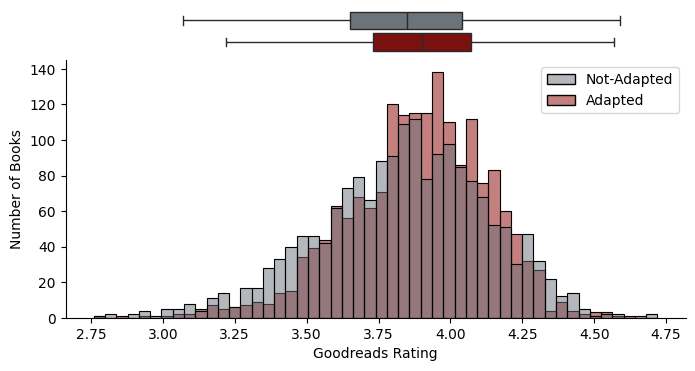

The p-value of the t-test is 1.750e-07.
The mean rating of adapted book is 0.05 higher than that of not-adapted books.


In [21]:
make_book_histplot_no_stack(df=trial_3_balanced_df, col='book_rating', x_label='Goodreads Rating')

# Compute the t-test
test_result = ttest_ind(trial_3_balanced_df.query('book_adapted == 1 & book_rating.notna()').book_rating,
                        trial_3_balanced_df.query('book_adapted == 0 & book_rating.notna()').book_rating)
print(f'The p-value of the t-test is {test_result.pvalue:.3e}.')

# Compute the difference in means
diff_means = trial_3_balanced_df.query('book_adapted == 1').book_rating.mean() - trial_3_balanced_df.query('book_adapted == 0').book_rating.mean()
print(f'The mean rating of adapted book is {diff_means:.2f} higher than that of not-adapted books.')

We have observed a statistically significant difference at the 5% level. However, the average Goodreads rating for an adapted book is only 0.05 points higher than that of a non-adapted book.

### 2.3 Do filmmakers tend to favor shorter or longer books for movie adaptations?
It's interesting to consider whether there's a difference in the number of pages between adapted and non-adapted books. For instance, very long books might be challenging to adapt into movies due to their extensive content. However, factors like genre and publication year could also play a role as potential confounders. By applying the matching method from section 2.2, we can account for these variables in our analysis.

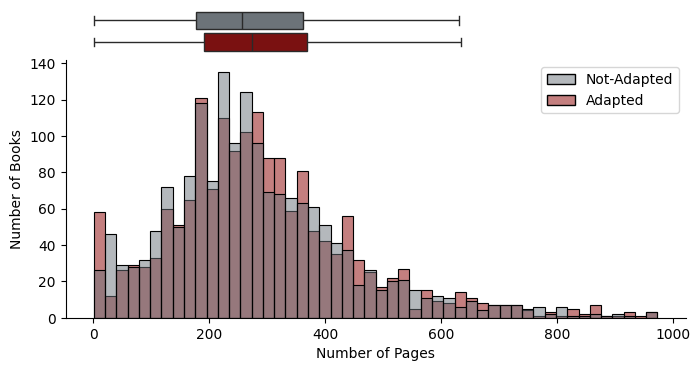

The p-value of the t-test is 0.172.
The average adapted book has 8.54 more pages than the average not-adapted book.


In [23]:
make_book_histplot_no_stack(df=trial_3_balanced_df.query('book_pages < 1000'), col='book_pages', x_label='Number of Pages')

# Compute the t-test
test_result = ttest_ind(trial_3_balanced_df.query('book_adapted == 1 & book_pages.notna()').book_pages,
                        trial_3_balanced_df.query('book_adapted == 0 & book_pages.notna()').book_pages)
print(f'The p-value of the t-test is {test_result.pvalue:.3f}.')

# Compute the difference in means
diff_means = trial_3_balanced_df.query('book_adapted == 1').book_pages.mean() - trial_3_balanced_df.query('book_adapted == 0').book_pages.mean()
print(f'The average adapted book has {diff_means:.2f} more pages than the average not-adapted book.')

For number of pages we could not find significant differences (at a 5% level) between adapted and non-adapted books. 

### 2.4 Are books that are adapted into movies typically more popular and critically acclaimed?
One might assume that Hollywood executives prefer to adapt books that are both popular and critically acclaimed. In this section, we will analyze if this assumption holds true. Since no information on global book sales is publicly available, we will use the number of ratings as a proxy, considering that books with higher sales are likely to have more readers who end up rating them. However, it's important to note that this is not a perfect measure. To assess critical acclaim, we will refer to Wikidata to see if the book has won any awards.

/Users/nifleisch/dev/uni/ada-2023/utils.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["log"] = np.log(df[col])


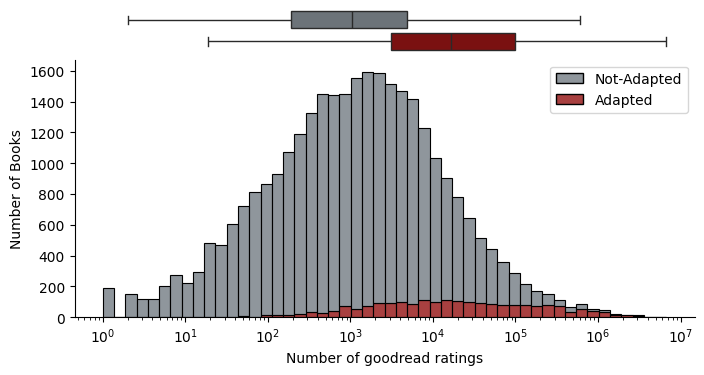

The p-value of the t-test is 0.000e+00.
The average adapted book has 143725.85 more ratings than the average not-adapted book.


In [24]:
make_book_histplot(df=adapted_book_df.query("book_ratings_count > 0"), col='book_ratings_count', x_label='Number of goodread ratings', log=True)

# Compute the t-test
test_result = ttest_ind(adapted_book_df.query('book_adapted == 1 & book_ratings_count.notna()').book_ratings_count,
                        adapted_book_df.query('book_adapted == 0 & book_ratings_count.notna()').book_ratings_count)
print(f'The p-value of the t-test is {test_result.pvalue:.3e}.')

# Compute the difference in means
diff_means = adapted_book_df.query('book_adapted == 1').book_ratings_count.mean() - adapted_book_df.query('book_adapted == 0').book_ratings_count.mean()
print(f'The average adapted book has {diff_means:.2f} more ratings than the average not-adapted book.')

As we hypothesized, adapted books are indeed more popular than non-adapted ones, as indicated by the number of ratings. This result is statistically significant at the 5% level. However, caution is advised in interpreting this result. There might be a feedback loop in the distribution of adapted books. Specifically, the Goodreads data could have been updated after the movie's release. We recognize that some people might read a book after its movie adaptation, potentially inflating the number of ratings on Goodreads. This could lead to target leakage in our analysis. However, we have chosen to retain the number of ratings as a predictor. After all the highly significant difference in the number of ratings is very unlikely to be solely attributed to this reinforcing loop.

Now, let's compare adapted and non-adapted books in terms of whether they are critically acclaimed. To account for differences in genre and publication date, we will use the matched dataframe from section 2.2.

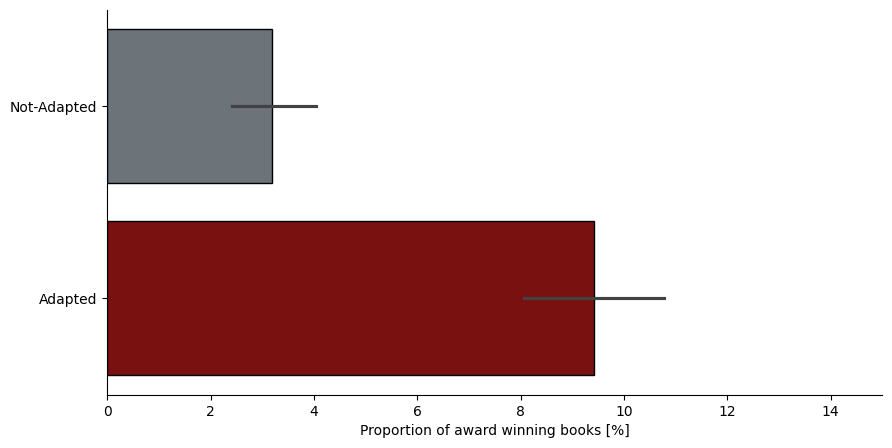

In [25]:
trial_3_balanced_df['book_won_price_pct'] = trial_3_balanced_df['book_won_price'] * 100

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=trial_3_balanced_df, y='label', x='book_won_price_pct', palette=['#6a737b', '#8B0000'], edgecolor='.0', ax=ax)
plt.xlabel('Proportion of award winning books [%]')
plt.ylabel('')

plt.xlim(0,15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

We can clearly observe a distinct difference between adapted and non-adapted books in terms of awards won. The 95% confidence intervals for the mean do not overlap, indicating that this result is statistically significant. This finding aligns with our assumption that Hollywood executives tend to make movies based on classic, award-winning books.

The fraction of non-adapted books that won a price is: 9.422%
The fraction of adapted books that won a price is: 3.197%


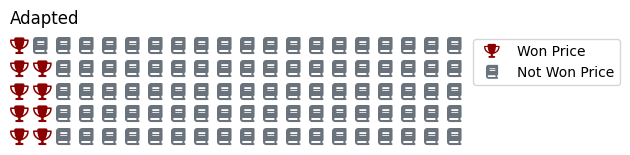

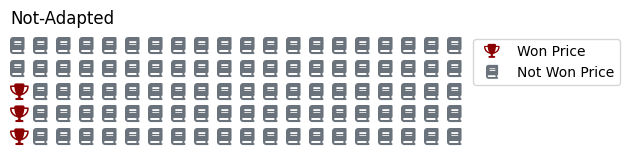

In [26]:
adapted_book_adapted_df = trial_3_balanced_df.query('book_adapted == 1')
adapted_book_not_adapted_df = trial_3_balanced_df.query('book_adapted == 0')

fraction_won_price = round(adapted_book_adapted_df.book_won_price.mean() * 100)
fraction_not_won_price = (100 - fraction_won_price)
data_adapted = {'Won Price': fraction_won_price, 'Not Won Price': fraction_not_won_price}

fraction_won_price = round(adapted_book_not_adapted_df.book_won_price.mean() * 100)
fraction_not_won_price = (100 - fraction_won_price)
data_not_adapted = {'Won Price': fraction_won_price, 'Not Won Price': fraction_not_won_price}

fig_1 = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=data_adapted,
    colors=['#8B0000', '#6a737b'],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons=['trophy', 'book'],
    font_size=12,
    icon_legend=True,
    title={'label': 'Adapted', 'loc': 'left'}
)

fig_2 = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=data_not_adapted,
    colors=['#8B0000', '#6a737b'],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)},
    icons=['trophy', 'book'],
    font_size=12,
    icon_legend=True,
    title={'label': 'Not-Adapted', 'loc': 'left'}
)

print("The fraction of non-adapted books that won a price is: %.3f%%" %(adapted_book_adapted_df.book_won_price.mean() * 100))
print("The fraction of adapted books that won a price is: %.3f%%" %(adapted_book_not_adapted_df.book_won_price.mean() * 100))

### 2.5 Are there certain book genres that are more suitable for movie adaptations?
Now, let's investigate whether certain genres are more prevalent among adaptations. However, we must proceed with caution, as the data from Wikidata might not be complete. Therefore, our analysis will only include books for which we have genre labels.

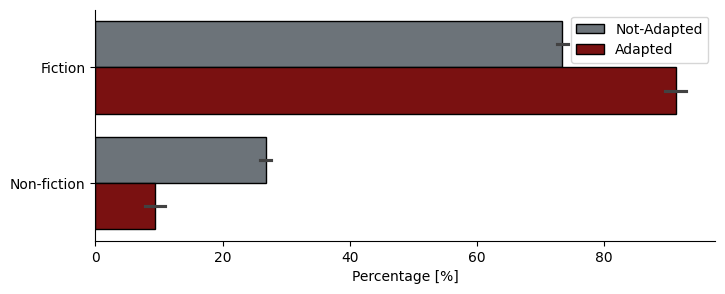

In [27]:
book_fiction_df = (adapted_book_df
                   .assign(
                     fiction_sum = adapted_book_df[fiction_cols].sum(axis=1)
                 )
                 .query('fiction_sum > 0')
                 .loc[:, fiction_cols + ['label']].copy(deep=True)
                 .melt(id_vars='label', var_name='genre', value_name='value')
                 .assign(
                     genre=lambda x: x.genre.str.replace('non_fiction', 'Non-Fiction').str.split('_').str[-1].str.capitalize(),
                     value= lambda x: x.value * 100
                 )
                )

# order the genres by the percentage of adapted books
order = (book_fiction_df
         .query('label == "Adapted"')
         .groupby(['genre'])
         .agg({'value': 'mean'})
         .reset_index()
         .sort_values('value', ascending=False)
         ['genre']
        )

# plot the results
fig, ax = plt.subplots(figsize=(8, 3))
sns.barplot(data=book_fiction_df, y='genre', x='value', hue='label', palette=['#6a737b', '#8B0000'], edgecolor='.0', ax=ax, order=order)
plt.xlabel('Percentage [%]')
plt.ylabel('')
ax.get_legend().set_title("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

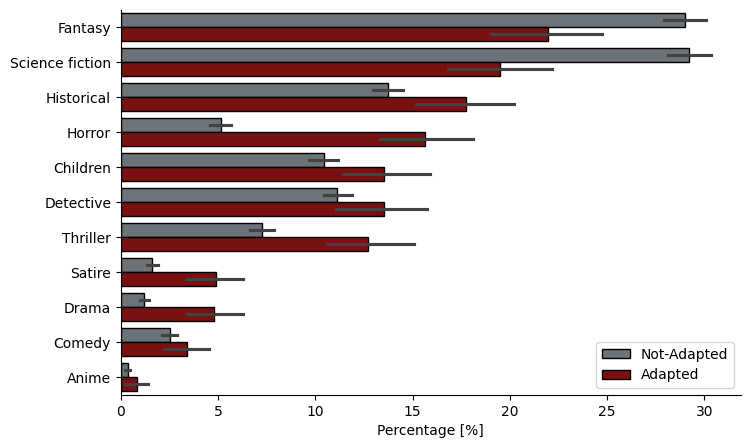

In [29]:
# filter adapted_book_df to only include for which the sum over the genre columns is larger than 0
book_genre_df = (adapted_book_df
                 .assign(
                     genre_sum = adapted_book_df[genre_cols].sum(axis=1)
                 )
                 .query('genre_sum > 0')
                 .loc[:, genre_cols + ['label']].copy(deep=True)
                 .melt(id_vars='label', var_name='genre', value_name='value')
                 .assign(
                     genre=lambda x: x.genre.str.replace('science_fiction', 'Science Fiction').str.split('_').str[-1].str.capitalize(),
                     value= lambda x: x.value * 100
                 )
                )

# order the genres by the percentage of adapted books
order = (book_genre_df
         .query('label == "Adapted"')
         .groupby(['genre'])
         .agg({'value': 'mean'})
         .reset_index()
         .sort_values('value', ascending=False)
         ['genre']
        )

# plot the results
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=book_genre_df, y='genre', x='value', hue='label', palette=['#6a737b', '#8B0000'], edgecolor='.0', ax=ax, order=order)
plt.xlabel('Percentage [%]')
plt.ylabel('')
ax.get_legend().set_title("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

Let's summarize and discuss our findings:
- `fiction vs. non-fiction`: As expected, a higher proportion of fiction books are found among adapted books compared to non-adapted ones.
- `fantasy and science fiction`: Although these remain the most common genres among adapted movies, their fraction is smaller compared to non-adapted movies. This might be explained by the fact that such movies are often expensive to adapt, despite being relatively easier to write.
- `historical, horror, children, thriller, satire, drama`: These genres show a significantly higher representation among adapted movies.

### 2.6 Is it more advantageous to adapt a standalone book or a book part of a series?
The question of whether books that are part of a series are more likely to be adapted into movies is intriguing. Series like "Harry Potter" or "The Lord of the Rings" are prominent examples of successful adaptations, which might suggest that being part of a series is a favorable factor for adaptation. To explore this hypothesis, you would analyze the proportion of adapted books that are part of a series compared to standalone books. This analysis can reveal whether there's a general trend toward adapting books from series more frequently than individual novels.

To ensure our analysis accounts for potential influences from genre and release year, we will once again utilize the matched dataframe from section 2.2. This approach will help us control for these variables, providing a more accurate understanding of whether books that are part of a series are more likely to be adapted into movies compared to standalone books.

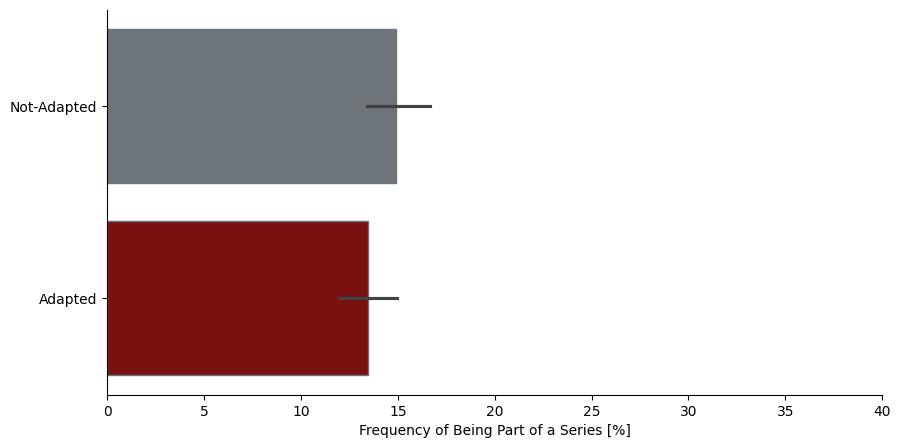

The fraction of non-adapted books that are part of a series is: 14.919%
The fraction of adapted books that are part of a series is: 13.460%


In [30]:
trial_3_balanced_df['book_part_of_series_pct'] = trial_3_balanced_df['book_part_of_series'] * 100

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=trial_3_balanced_df, y='label', x='book_part_of_series_pct', palette=['#6a737b', '#8B0000'], edgecolor='#6a737b', ax=ax)
plt.xlabel('Frequency of Being Part of a Series [%]')
plt.ylabel('')
plt.xlim(0,40)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

print("The fraction of non-adapted books that are part of a series is: %.3f%%" %(trial_3_balanced_df.query('label == "Not-Adapted"').book_part_of_series.mean() * 100))
print("The fraction of adapted books that are part of a series is: %.3f%%" %(trial_3_balanced_df.query('label == "Adapted"').book_part_of_series.mean() * 100))

Surprisingly, our analysis did not yield a significant result in determining whether books that are part of a series are more likely to be adapted into movies. In fact, we observed that the fraction of series books among non-adapted titles is slightly higher than that among adapted books. This outcome challenges the common assumption that series are more frequently adapted and suggests that other factors might be more influential in the decision to adapt a book into a movie.

### 2.7 Is it possible to predict which books will be selected for movie adaptations? If so, can we predict which books will be adapted next?
Our analysis has revealed that books which are adapted into movies often differ in several key aspects. Therefore, it should be feasible to train a classifier that can predict which books are likely to be adapted in the future using these significant predictors.

The features selected for the model include:

1. Book Rating: Reflecting the book's quality.
1. Number of Ratings: Proxy for the popularity of a book.
2. Number of Pages: To consider the book's length.
3. Fiction: If the book is fiction or non-fiction
3. Book Genre: Differentiating among various literary genres.
4. Fiction or Non-Fiction: Distinguishing between these two major categories.
5. Release Year: To consider the book's age.
6. Part of a Series: Identifying if the book is part of a series.
7. Award Winner: Whether the book has won any awards.

In [31]:
# select relevant predictors
X_cols = fiction_cols + genre_cols + ['book_release', 'book_part_of_series', 'book_ratings_count', 'book_won_price', 'book_rating', 'book_pages']
X = adapted_book_df.loc[:, X_cols].to_numpy()
y = adapted_book_df.loc[:, 'book_adapted'].to_numpy()

# define model pipeline
model_type = LogisticRegression()
pipe = (Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', model_type), 
    ])
)

sos = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ros = RandomOverSampler(random_state=42)

accuracies = []
precision_all=[]
recall_all=[]
accuracy_all=[]
f1_all=[]
thresholds_fixed=np.linspace(0,1,2000)
pred_df_list = []

# cross validation
for train_index, test_index in tqdm(sos.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # oversample adapted books and fit model
    X_train, y_train = ros.fit_resample(X_train, y_train)
    pipe.fit(X_train, y_train)
    accuracies.append(pipe.score(X_test, y_test))
    y_pred = pipe.predict(X_test)
    y_pred_proba=pipe.predict_proba(X_test)
    
    # Get performances
    precision, recall, thresholds = precision_recall_curve(y_test.ravel(),y_pred_proba[:,1].ravel())
    acc=[]
    for jj in thresholds_fixed:
        acc=acc+[sum((y_pred_proba[:,1]>=jj)==(y_test==1))/len(y_test)]
    precision_fixed=np.interp(thresholds_fixed,thresholds,precision[:-1])
    recall_fixed=np.interp(thresholds_fixed,thresholds,recall[:-1])
    precision_all=precision_all+[precision_fixed]
    recall_all=recall_all+[recall_fixed]
    f1_all=f1_all+[2*precision_fixed*recall_fixed/(precision_fixed+recall_fixed)]
    accuracy_all=accuracy_all+[acc]
    pred_df_list.append(pd.DataFrame(X_test, columns=X_cols)
                        .assign(
                            proba = pipe.predict_proba(X_test)[:, 1],
                            y = y_test
                        )
                        .merge(adapted_book_df.iloc[test_index,:], 
                               on=X_cols, 
                               how='inner')
                        )

5it [00:07,  1.56s/it]


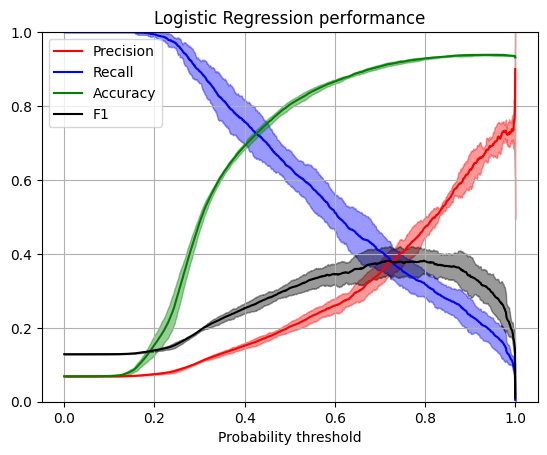

In [32]:
def high_ci(x):
    return x.mean() + 1.96*x.std()
def low_ci(x):
    return x.mean() -1.96 *x.std()

def performance_plot():
    precision_result = pd.DataFrame(precision_all).transpose()
    precision_result['mean'] = precision_result.mean(axis=1)
    precision_result['high_ci'] = precision_result.apply(lambda x:high_ci(x),axis=1)
    precision_result['low_ci'] = precision_result.apply(lambda x:low_ci(x),axis=1)
    precision_result["Threshold"] = thresholds_fixed

    accuracy_result = pd.DataFrame(accuracy_all).transpose()
    accuracy_result['mean'] = accuracy_result.mean(axis=1)
    accuracy_result['high_ci'] = accuracy_result.apply(lambda x:high_ci(x),axis=1)
    accuracy_result['low_ci'] = accuracy_result.apply(lambda x:low_ci(x),axis=1)
    accuracy_result["Threshold"] = thresholds_fixed

    recall_result = pd.DataFrame(recall_all).transpose()
    recall_result['mean'] = recall_result.mean(axis=1)
    recall_result['high_ci'] = recall_result.apply(lambda x:high_ci(x),axis=1)
    recall_result['low_ci'] = recall_result.apply(lambda x:low_ci(x),axis=1)
    recall_result["Threshold"] = thresholds_fixed

    f_1_result = pd.DataFrame(f1_all).transpose()
    f_1_result['mean'] = f_1_result.mean(axis=1)
    f_1_result['high_ci'] = f_1_result.apply(lambda x:high_ci(x),axis=1)
    f_1_result['low_ci'] = f_1_result.apply(lambda x:low_ci(x),axis=1)
    f_1_result["Threshold"] = thresholds_fixed

    plt.plot(precision_result['Threshold'],precision_result['mean'],c='red')
    plt.plot(recall_result['Threshold'],recall_result['mean'],c='blue')
    plt.plot(accuracy_result['Threshold'],accuracy_result['mean'],c='green')
    plt.plot(f_1_result['Threshold'],f_1_result['mean'],c='black')
    plt.legend(['Precision','Recall','Accuracy', 'F1'])
    plt.fill_between(precision_result['Threshold'].values,precision_result['high_ci'].values,precision_result['low_ci'].values,color='red',alpha=0.4)
    plt.fill_between(recall_result['Threshold'].values,recall_result['high_ci'].values,recall_result['low_ci'].values,color='blue',alpha=0.4)
    plt.fill_between(accuracy_result['Threshold'].values,accuracy_result['high_ci'].values,accuracy_result['low_ci'].values,color='green',alpha=0.4)
    plt.fill_between(f_1_result['Threshold'].values,f_1_result['high_ci'].values,f_1_result['low_ci'].values,color='black',alpha=0.4)
    plt.grid()
    plt.ylim([0,1])
    plt.xlabel('Probability threshold')
    plt.title(" ".join(re.findall('[A-Z][^A-Z]*',str(model_type).split('()')[0]))+" performance")
    plt.savefig("assets/"+str(model_type).split('()')[0]+"_performance"+".pdf", bbox_inches="tight")

performance_plot()

In [33]:
# select relevant predictors
X_cols = fiction_cols + genre_cols + ['book_release', 'book_part_of_series', 'book_ratings_count', 'book_won_price', 'book_rating', 'book_pages']
X = adapted_book_df.loc[:, X_cols].to_numpy()
y = adapted_book_df.loc[:, 'book_adapted'].to_numpy()

# define model pipeline
model_type = RandomForestClassifier()
pipe = (Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', model_type), 
    ])
)

sos = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ros = RandomOverSampler(random_state=42)

accuracies = []
precision_all=[]
recall_all=[]
accuracy_all=[]
f1_all=[]
thresholds_fixed=np.linspace(0,1,2000)
pred_df_list = []
importances = []

for train_index, test_index in tqdm(sos.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # oversample adapted books and fit model
    X_train, y_train = ros.fit_resample(X_train, y_train)
    pipe.fit(X_train, y_train)
    importances.append(pipe.named_steps['classifier'].feature_importances_)
    accuracies.append(pipe.score(X_test, y_test))
    y_pred = pipe.predict(X_test)
    y_pred_proba=pipe.predict_proba(X_test)
    
    # Get performances
    precision, recall, thresholds = precision_recall_curve(y_test.ravel(),y_pred_proba[:,1].ravel())
    acc=[]
    for jj in thresholds_fixed:
        acc=acc+[sum((y_pred_proba[:,1]>=jj)==(y_test==1))/len(y_test)]
    precision_fixed=np.interp(thresholds_fixed,thresholds,precision[:-1])
    recall_fixed=np.interp(thresholds_fixed,thresholds,recall[:-1])
    precision_all=precision_all+[precision_fixed]
    recall_all=recall_all+[recall_fixed]
    accuracy_all=accuracy_all+[acc]
    f1_all=f1_all+[2*precision_fixed*recall_fixed/(precision_fixed+recall_fixed)]
    pred_df_list.append(pd.DataFrame(X_test, columns=X_cols)
                        .assign(
                            proba = pipe.predict_proba(X_test)[:, 1],
                            y = y_test
                        )
                        .merge(adapted_book_df.iloc[test_index,:], 
                               on=X_cols, 
                               how='inner')
                        )

print(f'Mean Accuracy: {np.mean(accuracies):.2f} +- {np.std(accuracies):.3f}')

5it [00:29,  5.84s/it]

Mean Accuracy: 0.95 +- 0.003


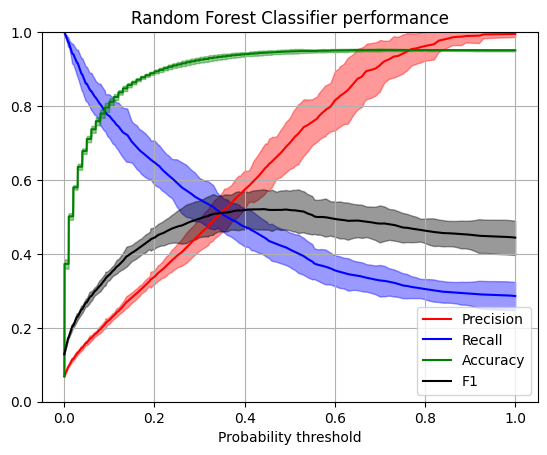

In [34]:
performance_plot()

When comparing both models, it is crucial to consider recall and precision, as accuracy alone is not a reliable metric due to the high imbalance in the dataset. The F1 score, which combines both precision and recall into a single metric, demonstrates that the random forest classifier outperforms the logistic regression classifier.

It's important to note that the relatively low values for precision and recall are expected. This is because some books that we categorized as non-adapted might already have been adapted, but this information could be missing in our dataset. Additionally, there might be books that meet all the criteria for adaptation, but the author may not wish to grant adaptation rights. Furthermore, some of these books might be adapted in the future. So it is indeed a difficult classification problem.

Let us determine the optimal threshold for the random forest classifier in order to maximize the f1-score. 

In [35]:
f_1_result = pd.DataFrame({'threshold': thresholds_fixed, 'mean': np.array(f1_all).mean(axis=0)})
threshold = f_1_result.loc[f_1_result['mean'].idxmax(), 'threshold']
print(f'The threshold with the highest F1 score is {threshold:.3f} and leads to a F1 score of {f_1_result["mean"].max():.3f}.')

The threshold with the highest F1 score is 0.440 and leads to a F1 score of 0.521.


Let us use this threshold to determine books that are likely to be adapted in the future. 

In [36]:
candidates_df = (pd.concat(pred_df_list, axis=0)
                 .drop_duplicates(subset=['book_wikidata_id'])
                 .query('y == 0 & proba > 0.440')
                )

print("We found a total of {} books that are likely to be adapted.".format(len(candidates_df)))

We found a total of 532 books that are likely to be adapted.


In [37]:
candidates_df.sort_values('proba', ascending=False).head(10).loc[:, ['book_title', 'book_author', 'proba']]

,book_title,book_author,proba
116,Delta of Venus,Anaïs Nin,1.00
22,Chilly Scenes of Winter,Ann Beattie,1.00
1616,His Last Bow,Arthur Conan Doyle,1.00
378,Ten Little Niggers,Agatha Christie,0.92
3776,Sophie's World,Jostein Gaarder,0.92
2859,To the Lighthouse,Virginia Woolf,0.91
107,Black Beauty: retold in words of one syllable,Anna Sewell,0.88
1213,North and South,Elizabeth Cleghorn Gaskell,0.87
5053,The Merry Adventures of Robin Hood,Howard Pyle,0.85
5628,The Maltese Falcon,Dashiell Hammett,0.84


Interestingly all of our top ten predictions have a movie adaptation or tv-series adaptation by now. 

To better understand how the Random Forest classifier ended up with these candidates. Therefore we use the impurity based feature importance reported by scikit-learn.

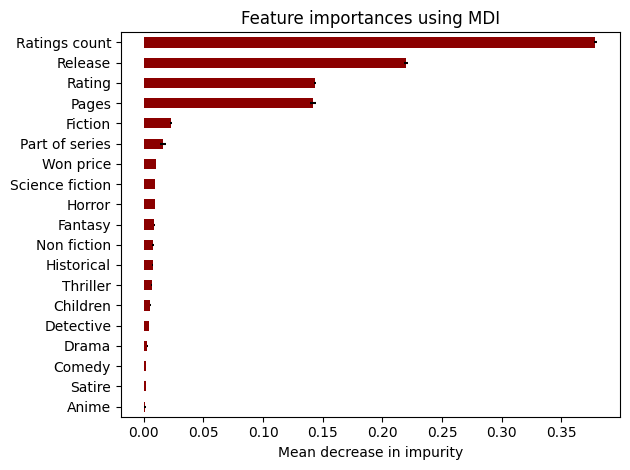

In [38]:
mean = np.mean(importances, axis=0)
std = np.std(importances, axis=0)
X_cols = [" ".join(col.replace('book_', '').split('_')).capitalize() for col in X_cols]
forest_importances = pd.Series(mean, index=X_cols)

fig, ax = plt.subplots()
# make horizontal bar chart sorted by importance with red color 
forest_importances.sort_values(ascending=True).plot.barh(xerr=std, ax=ax, color='#8B0000')
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()

The Random Forest classifier primarily depends on the following predictors: ratings count (which serves as a proxy for popularity), release date, rating, and the number of pages. Particularly interesting is the last predictor, the number of pages. This is noteworthy because, when we analyzed the number of pages individually, we didn't find significant differences between adaptations and non-adaptations. Additionally, it appears that the classifier does not heavily rely on genre predictors.

# 3 What makes a commercially successful book adaptation?**
The findings from Chapter 2 present us with 600 books that have strong potential for successful adaptations. As Hollywood executives tasked with making a choice, we must consider the financial implications, especially since acquiring rights for some of these books can cost millions. Our goal is to identify the books that are most likely to generate the highest revenue. To achieve this, we will examine how specific attributes of books correlate with their revenue generation. This analysis will lead us to develop a predictive model that can guide us in making an informed decision about which book to adapt.

### 3.1 Is there a book genre that leads to successful adaptations?
Let's begin by examining genres. Is there a particular book genre for which adaptations typically generate significantly more revenue than others? Again we only considered books for which data about the genre was available. 

In [39]:
# we only will consider books that have a movie adaptation for which revenue data is available
adaptation_revenue_df = adaptation_df.query('movie_is_adaptation == 1 & movie_revenue.notnull()')

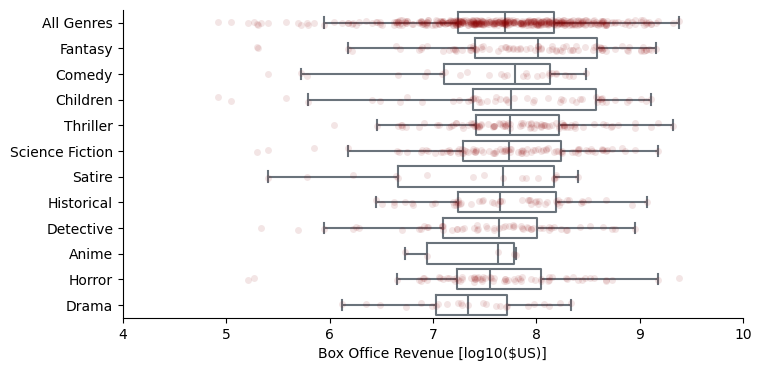

In [40]:
genre_list = []
genre_list.append(adaptation_revenue_df
                  .assign(
                     genre_sum = adaptation_revenue_df[genre_cols].sum(axis=1)
                  )
                  .query('genre_sum > 0')
                  .assign(genre = "All Genres")
                  .loc[:, ['genre', 'movie_revenue_log']]
                 )

for col in genre_cols:
    genre_list.append(adaptation_revenue_df
                      .query(f'{col} == 1')
                      .assign(genre = " ".join(col.split('_')[1:]).replace('_', ' ').title())
                      .loc[:, ['genre', 'movie_revenue_log']]
            )
genre_df = pd.concat(genre_list, axis=0)
genre_order = (genre_df
         .query('genre != "All Genres"')
         .groupby('genre')
         .agg({'movie_revenue_log': 'median'})
         .sort_values('movie_revenue_log', ascending=False)
         .index
         .tolist()
        )
genre_order = ['All Genres'] + genre_order

fig = plt.figure(figsize=(8, 4))
ax = sns.boxplot(
    data=genre_df, x="movie_revenue_log", y="genre", color='#6a737b', 
    fill=False, flierprops={"marker": None}, order=genre_order
)
sns.stripplot(
    data=genre_df, x="movie_revenue_log", y="genre", alpha=.1, color='#8B0000', ax=ax, 
    order=genre_order
)

ax.set_xlabel('Box Office Revenue [log10($US)]')
# set x lim 
ax.set_xlim(4, 10)
ax.set_ylabel('')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

Based on the plot, it's evident that fantasy books outperform other genres in terms of revenue, followed by comedy and children's books. In contrast, drama and horror books tend to perform the worst. However, to determine whether these differences are statistically significant, we should conduct some t-tests.

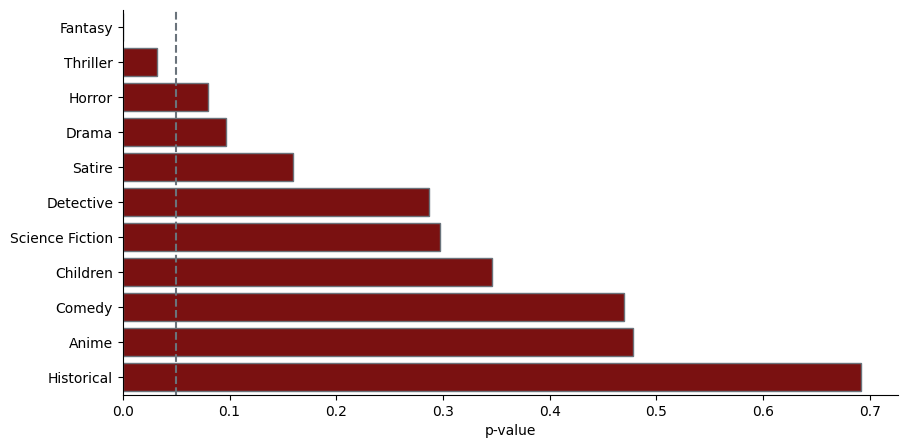

In [41]:
genre_adaptation_revenue_df = (adaptation_revenue_df
                                .assign(
                                    genre_sum = adaptation_revenue_df[genre_cols].sum(axis=1)
                                )
                                .query('genre_sum > 0')
                              )

results = []
for col in genre_cols:
    t_test_result = ttest_ind(genre_adaptation_revenue_df.query(f'{col} == 1').movie_revenue_log,
                              genre_adaptation_revenue_df.query(f'{col} == 0').movie_revenue_log)
    results.append({"genre": " ".join(col.split('_')[1:]).replace('_', ' ').title(), "t_test_p_value": t_test_result.pvalue})
results_df = pd.DataFrame(results).sort_values('t_test_p_value', ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=results_df, y='genre', x='t_test_p_value', color='#8B0000', edgecolor='#6a737b', ax=ax)
plt.xlabel('p-value')
plt.ylabel('')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.axvline(x=0.05, color='#6a737b', linestyle='--')
plt.show()

Surprisingly only the result for fantasy and thriller seem to be statistically significant (at a 5% level). 

### 3.2 Do book adaptations on book series perform better at the box office?
Considering successful book adaptations, series like "Lord of the Rings" and "Harry Potter" stand out. This leads us to investigate whether adaptations of book series generally yield better box office performance. However, caution is needed in this analysis. As observed in section 3.1, certain genres, like fantasy, naturally perform better at the box office. If book series are more prevalent in these high-performing genres, it could skew our results. To account for this, we will implement exact matching by genre to ensure a more accurate assessment.

In [42]:
# match treatment and control groups
treatment_df = adaptation_revenue_df.query('book_part_of_series == 1').reset_index(drop=False)
control_df = adaptation_revenue_df.query('book_part_of_series == 0').reset_index(drop=False)

matching_df = (treatment_df
               .merge(
                   control_df, 
                   on=fiction_cols + genre_cols, 
                   suffixes=['_treatment', '_control'],
                   how='inner'
                   )
            )

# build graph for matching
G = nx.Graph()
for _, row in tqdm(matching_df.iterrows(), total=len(matching_df), desc='Building Graph'):
    index_control = row['index_control']
    index_treatment = row['index_treatment']
    G.add_edges_from([(index_control, index_treatment)])

print('Computing Maximum Matching...')
matching = nx.maximal_matching(G)
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
trial_4_balanced_df = adaptation_revenue_df.loc[matched]

Building Graph: 100%|██████████| 25969/25969 [00:03<00:00, 6586.16it/s] 

Computing Maximum Matching...


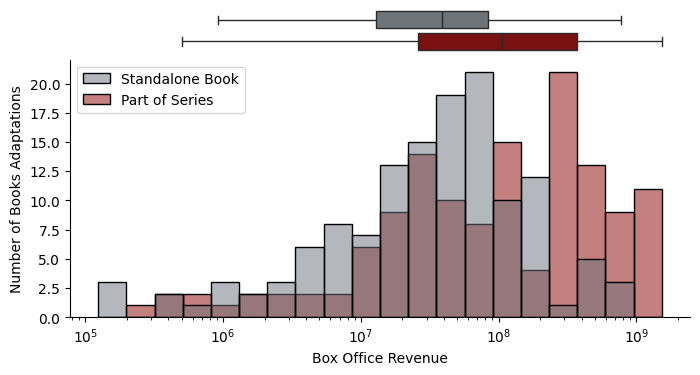

In [43]:
make_book_revenue_histplot_no_stacking(df=trial_4_balanced_df, col="book_part_of_series", labels=['Part of Series', 'Standalone Book'])

In [44]:
# Compute the t-test
test_result = ttest_ind(trial_4_balanced_df.query('book_part_of_series == 1').movie_revenue_log,
          trial_4_balanced_df.query('book_part_of_series == 0').movie_revenue_log)
print(f'The p-value of the t-test is {test_result.pvalue:.14f}')

# Fit linear model to compute impact
model = smf.ols('movie_revenue_log ~ book_part_of_series', data=trial_4_balanced_df)
results = model.fit()
intercept = results.params[0]
slope = results.params[1]
book_adaptation_impact_million = (10**(intercept + slope) - 10**intercept)/1e6
print(f'Impact of being part of series [in million $US]: {book_adaptation_impact_million:.2f}')

The p-value of the t-test is 0.00000470567646
Impact of being part of series [in million $US]: 54.63


Despite the small sample size for the statistical t-test, we observed a significant result at the 5% level. Additionally, it appears that, on average, adaptations based on book series generate approximately 55 million dollars more in revenue compared to those that are not.

### 3.3 What is the ideal time frame between a book's publication and its adaptation?
Once we've selected a book for adaptation, an important question arises: how long should we wait before releasing the movie? Releasing it too soon might mean that potential viewers haven't read the book yet, or they may have just read it and aren't interested in seeing a film adaptation so soon. On the other hand, waiting too long could lead to the audience losing interest or forgetting about the book. Therefore, it's crucial to determine if there's an optimal timeframe for the release to maximize audience engagement and interest.

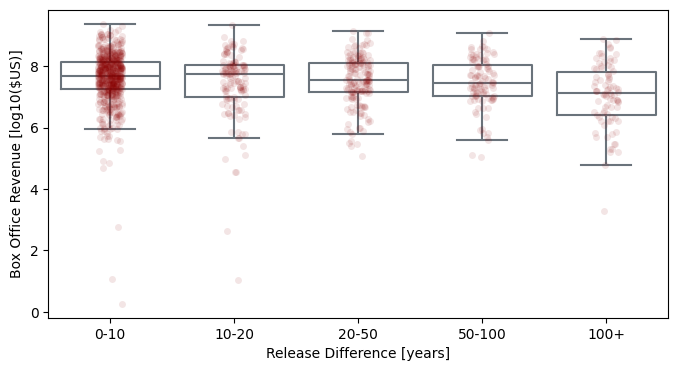

In [45]:
# ignore warnings
pd.options.mode.chained_assignment = None
adaptation_revenue_df['release_diff'] = adaptation_revenue_df.movie_release - adaptation_revenue_df.book_release
adaptation_revenue_df['release_diff_binned'] = pd.cut(adaptation_revenue_df.release_diff,
                                               bins=[0, 10, 20, 50, 100, 1000], 
                                               labels=['0-10', '10-20', '20-50', '50-100', '100+']) 

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(
    data=adaptation_revenue_df, x='release_diff_binned', y='movie_revenue_log', 
    color='#6a737b', ax=ax, fill=False, flierprops={"marker": None})

sns.stripplot(
    data=adaptation_revenue_df, x="release_diff_binned", y="movie_revenue_log", alpha=.1, color='#8B0000', ax=ax
)
ax.set_xlabel('Release Difference [years]')
ax.set_ylabel('Box Office Revenue [log10($US)]')
plt.show()

Analyzing the median revenue across different time intervals, we observe a slight increase in revenue from the 0-10 to the 10-20 year intervals, followed by a decline, with the lowest revenues occurring for adaptations of books over 100 years old. This suggests that selecting recently released books might be more advantageous than opting for very old ones. However, it's important to note that, according to the plot, the differences in revenue across these intervals do not appear to be very pronounced.

### 3.4 How does the popularity of the book affect the box office revenue?
A natural assumption is that well-loved, highly-rated books with a large fanbase tend to perform better at the box office. To test this, we will explore the pearson correlation between the book's rating and the number of ratings it has received with the movie's logarithmic revenue. This approach will help us understand if a book's popularity and quality are reliable indicators of its film adaptation's financial success. 

To ensure the robustness of our analysis regarding book ratings, we will only consider entries that have received at least 10 ratings. This criterion will help filter out books with too few ratings, which might not accurately reflect the broader audience's opinion. By setting this minimum threshold, we aim to use more reliable data for assessing the correlation between book ratings and movie revenue.

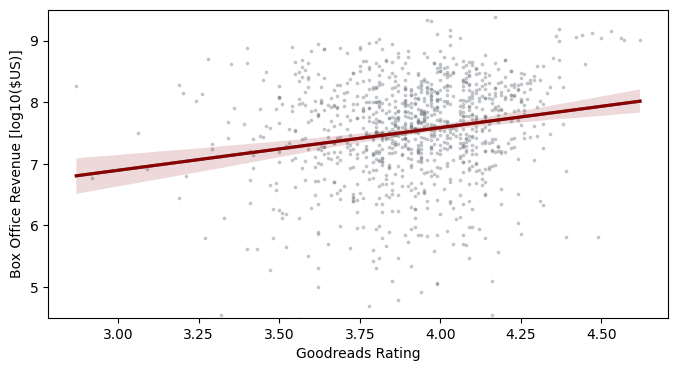

Pearson Correlation: 0.15, p-value: 0.00000097679622
Intercept: 5.41, Slope: 0.54


In [47]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.regplot(
    data=adaptation_revenue_df.query('book_ratings_count > 10'), 
    x="book_rating", y="movie_revenue_log", 
    color='#6a737b', ax=ax, 
    scatter_kws={'alpha': 0.3, 's': 3}, ci=None
    )
sns.regplot(
    data=adaptation_revenue_df.query('book_ratings_count > 10'), 
    x="book_rating", y="movie_revenue_log", 
    color='#8B0000', ax=ax, scatter=False
    )
ax.set_ylim(4.5, 9.5)
ax.set_xlabel('Goodreads Rating')
ax.set_ylabel('Box Office Revenue [log10($US)]')
plt.show()

# compute pearson correlation and p-value
pearson =  pearsonr(adaptation_revenue_df.query('book_rating.notna()').movie_revenue_log,
                    adaptation_revenue_df.query('book_rating.notna()').book_rating)
print(f'Pearson Correlation: {pearson[0]:.2f}, p-value: {pearson[1]:.14f}')

# fit linear regression model and print coefficient
model = smf.ols('movie_revenue_log ~ book_rating', data=adaptation_revenue_df.query('book_rating.notna()'))
results = model.fit()
intercept = results.params[0]
slope = results.params[1]
print(f'Intercept: {intercept:.2f}, Slope: {slope:.2f}')

The analysis reveals a weak but significant Pearson correlation of 0.15, suggesting that better-rated books tend to lead to higher movie revenues. With the linear regression model having a slope of 0.54 and a bias of 5.41, this implies that for every one-point increase in a book's Goodreads rating, the logarithm of the movie's revenue increases by 0.54.

For example, consider a book with a rating of 3.5. If its rating increased by 1 point (to 4.5):
- The current revenue (with a rating of 3.5) is approximately $19,952,623.
- With the increased rating (to 4.5), the new revenue is approximately $69,183,097.
- This results in a difference of about $49,230,474 in actual revenue due to the one-point increase in the book's rating.

As we have already seen in 2.4 the number of ratings seems to follow a power law distribution. For this reason we will apply the logarithm to it. Therefore we first filter out all entries for which the number of ratings is 1 or less. 

In [48]:
adaptation_revenue_df = (adaptation_revenue_df
                         .query('book_ratings_count > 1')
                         .assign(
                             book_ratings_count_log = np.log10(adaptation_revenue_df.book_ratings_count)
                         )
                        )

/Users/nifleisch/dev/uni/ada-2023/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


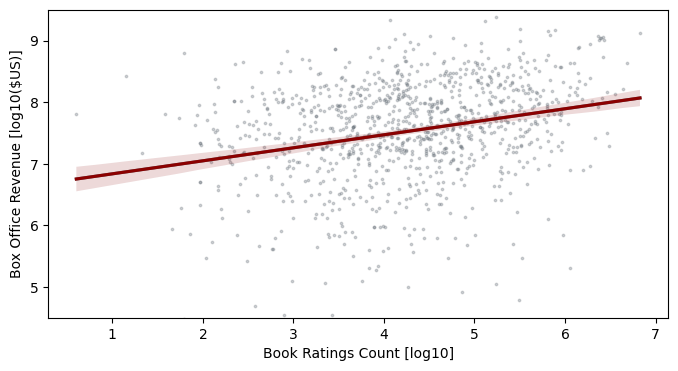

Pearson Correlation: 0.25, p-value: 9.538e-16
Intercept: 4.82, Slope: 0.69


In [49]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.regplot(
    data=adaptation_revenue_df, 
    x="book_ratings_count_log", y="movie_revenue_log", 
    color='#6a737b', ax=ax, 
    scatter_kws={'alpha': 0.3, 's': 3}, ci=None
    )
sns.regplot(
    data=adaptation_revenue_df, 
    x="book_ratings_count_log", y="movie_revenue_log", 
    color='#8B0000', ax=ax, scatter=False
    )
ax.set_ylim(4.5, 9.5)
ax.set_xlabel('Book Ratings Count [log10]')
ax.set_ylabel('Box Office Revenue [log10($US)]')
plt.show()

# compute pearson correlation and p-value
pearson =  pearsonr(adaptation_revenue_df.movie_revenue_log,
                    adaptation_revenue_df.book_ratings_count_log)
print(f'Pearson Correlation: {pearson[0]:.2f}, p-value: {pearson[1]:.3e}')

# fit linear regression model and print coefficient
model = smf.ols('movie_revenue_log ~ book_rating', data=adaptation_revenue_df.query('book_rating.notna()'))
results = model.fit()
intercept = results.params[0]
slope = results.params[1]
print(f'Intercept: {intercept:.2f}, Slope: {slope:.2f}')

The scatter plot indicates a positive relationship between the log-transformed book ratings count and the log-transformed box office revenue, with a Pearson correlation coefficient of 0.25. This correlation is statistically significant (at 5% level). The regression line has an intercept of 4.82 and a slope of 0.69, suggesting that as the log10 of the book ratings count increases, the log10 of the box office revenue also increases.

Concretely, the slope of 0.69 means that for each tenfold increase in the book ratings count, we can expect, on average, the box office revenue to be multiplied by approximately $10^{0.69}$, or about 4.9 times, holding other factors constant. This significant correlation confirms the assumption that books with a larger number of ratings, indicating a bigger fanbase, are likely to translate into greater box office success.

### 3.5 Can we predict the expected revenue of a future book adaptation? If so, which adaptation would perform best at the box office?
Now, let's attempt to predict the revenue of book adaptations using the attributes of the book. We'll use the data from books that have already been adapted for training purposes. To estimate the performance in terms of mean squared error (MSE), we will employ a 5-fold cross-validation strategy. This approach will help validate our model's predictive power and ensure its reliability across different subsets of the data. Further given the limited data we have available, we will employ Ridge regression with $\alpha = 0.1$ to avoid overfitting. 

In [50]:
# select relevant predictors
reg_cols = genre_cols + fiction_cols + ['book_part_of_series', 'book_won_price', 'book_rating', 'book_ratings_count_log', 'book_pages', 'release_diff']
X = adaptation_revenue_df.loc[:, reg_cols].to_numpy()
y = adaptation_revenue_df.loc[:, 'movie_revenue_log'].to_numpy()

# define model pipeline
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('reg', Ridge(alpha=0.1, random_state=42))
])

# cross validation
scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
mae_scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_absolute_error')

print(f'Mean MSE: {-np.mean(scores):.2f} +- {np.std(scores):.3f}')
print(f'Mean MAE: {-np.mean(mae_scores):.2f} +- {np.std(mae_scores):.3f}')

Mean MSE: 0.71 +- 0.126
Mean MAE: 0.61 +- 0.045


The results show a mean MSE of 0.70 with a standard deviation of 0.130, and a mean MAE of 0.61 with a standard deviation of 0.048. These metrics provide an estimate of the model's average error magnitude in predicting the logarithm of movie revenue, with lower values indicating better performance. The low standard deviations suggest that the model's predictions are consistent across the different folds of the cross-validation.

Now refit the Ridge Regression model on the whole dataset. 

In [51]:
# refit the model on the whole dataset
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('reg', Ridge(alpha=0.1, random_state=42))
])
pipe.fit(X, y)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('reg', Ridge(alpha=0.1, random_state=42))])

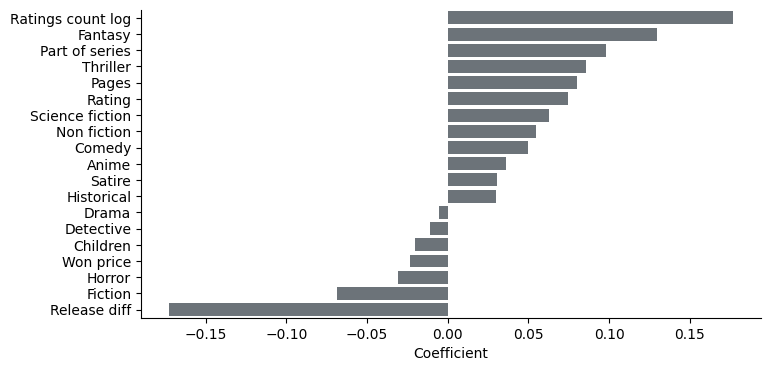

In [52]:
# get coefficients and plot them
coefs = pipe.named_steps['reg'].coef_
clean_reg_cols = [" ".join(col.replace('book_', '').split('_')).capitalize() for col in reg_cols]
coefs = pd.Series(coefs, index=clean_reg_cols)
coefs = coefs.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=coefs.values, y=coefs.index, color='#6a737b', ax=ax)
plt.xlabel('Coefficient')
plt.ylabel('')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

The feature with the highest positive coefficient is `book_ratings_count_log`, indicating that a higher log-transformed count of book ratings is associated with increased revenue. `book_fantasy` and `book_part_of_series` also have positive coefficients, suggesting that books in the fantasy genre and those that are part of a series are likely to yield higher revenues when adapted.

Conversely, the features at the bottom of the chart, such as `release_diff`, `book_horror`, and `book_won_price` have negative coefficients, implying a negative relationship with revenue. Specifically, the `release_diff` coefficient suggests that a longer interval between the book release and the movie adaptation may be associated with lower revenue. Surprisingly, books that one a price perform worse at the box office according to this model. 

Now let us determine for which of the candidates we curated in section 2 the model predicts the highest revenue. 

In [56]:
candidates_df = candidates_df.assign(
    # as we considered data from 1950 to 2010, we try to predict which books will be adapted in 2011
    release_diff = lambda x: (2011 - x.book_release),
    book_ratings_count_log = lambda x: np.log10(x.book_ratings_count)
    )

X_candidates = candidates_df.loc[:, reg_cols].to_numpy()
candidates_df['pred_log_revenue'] = pipe.predict(X_candidates)
(candidates_df
    .assign(pred_revenue = lambda x: 10**x.pred_log_revenue)
    .sort_values(by='pred_log_revenue', ascending=False)
    .loc[:, ['book_title', 'book_author', 'pred_revenue']]
    .head(10)
)

,book_title,book_author,pred_revenue
1147,A Game of Thrones,George R. R. Martin,6.690102e+08
1874,A Clash of Kings,George R. R. Martin,4.939812e+08
3574,Kafka on the Shore,Haruki Murakami,2.964202e+08
2891,Harry Potter and the Prisoner of Azkaban,J. K. Rowling,2.658899e+08
3193,The Shadow of the Wind,Carlos Ruiz Zafón,2.172798e+08
5656,The Sea of Monsters,Rick Riordan,2.106567e+08
1137,Holes,Louis Sachar,1.936324e+08
5603,Equal Rites,Terry Pratchett,1.897614e+08
5654,Killing Floor,Lee Child,1.843552e+08
813,Red Storm Rising,Tom Clancy,1.679095e+08


Let's take a closer look at this list one item at a time:

- "Game of Thrones" may not have become a major movie adaptation, but it found remarkable success as a television series, arguably becoming one of the most successful TV series ever.
- "Kafka on the Shore" remains untouched by filmmakers and has not been adapted into a movie.
- "Harry Potter and the Prisoner of Azkaban" stands out as a movie adaptation, often hailed as the best in the Harry Potter series. Notably, it was absent from our dataset.
- "The Shadow of the Wind" has the potential for a great movie; however, [the author turned down some offers from film studios, as reported by The Wall Street Journal](https://www.wsj.com/articles/SB10001424052748704852004575258590531491332).
- "The Sea of Monsters" received its movie adaptation in 2013 but only grossed [200 million dollars](https://en.wikipedia.org/wiki/Percy_Jackson:_Sea_of_Monsters).
- "Holes" was adapted into a film in 2003, which earned a global box office total of [71 million dollars](https://en.wikipedia.org/wiki/Holes_(film)).
- "Equal Rites" hasn't been adapted yet, presenting an opportunity for Hollywood executives to consider.
- "Killing Floor" was successfully brought to screens as the [TV series "Reacher" in 2022](https://en.wikipedia.org/wiki/Reacher_(TV_series)).
- While "Red Storm Rising" has not been made into a movie, it inspired an [excellent board game](https://en.wikipedia.org/wiki/Red_Storm_Rising#Game_adaptations).